In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! pip install catboost

     |████████████████████████████████| 65.8MB 47kB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import *
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier

In [7]:
train_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_err_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_problem_data.csv')
test_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/test_err_data.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/데이콘/data/sample_submission.csv')

In [8]:
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [9]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))

for person_idx, err in tqdm(id_error):
  error[person_idx-10000,err-1]+=1
error.shape

100%|██████████| 16554663/16554663 [00:39<00:00, 420751.65it/s]


(15000, 42)

In [10]:
problem_df = pd.DataFrame(problem)
problem_df.rename({0:'problem'},axis=1,inplace=True)
problem_df['problem'].value_counts()

0.0    10000
1.0     5000
Name: problem, dtype: int64

In [11]:
train_x = error
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 42)
(15000,)


In [13]:
train_y

array([0., 1., 0., ..., 1., 1., 0.])

In [12]:
smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_sample(train_x,train_y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (20000, 42) (20000,)
SMOTE 적용 후 레이블 값 분포:
 1.0    10000
0.0    10000
dtype: int64


In [ ]:
x_df

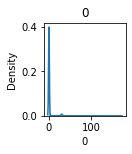

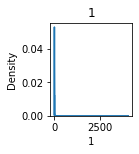

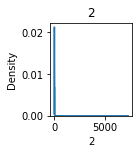

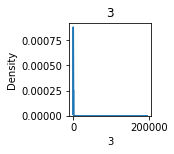

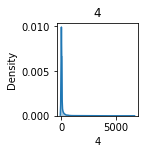

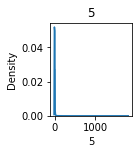

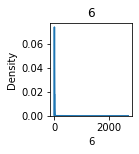

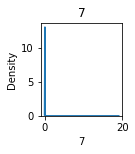

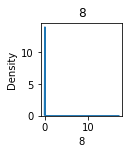

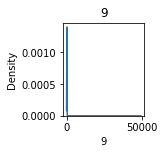

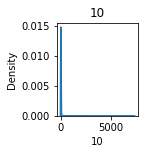

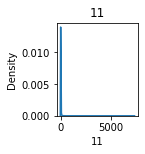

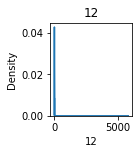

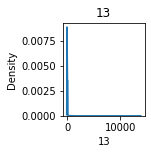

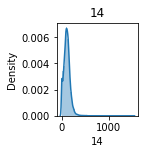

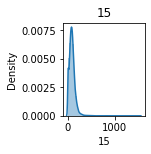

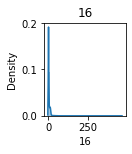

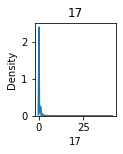

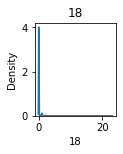

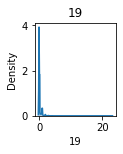

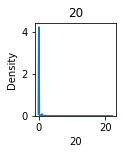

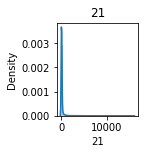

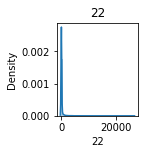

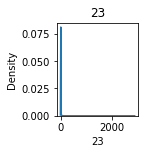

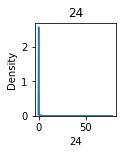

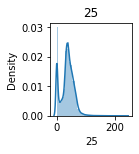

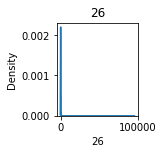

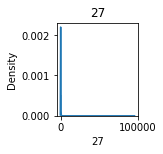

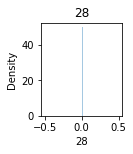

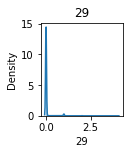

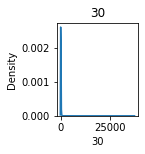

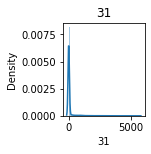

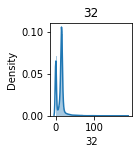

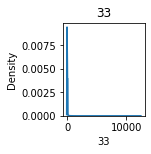

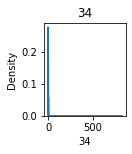

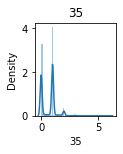

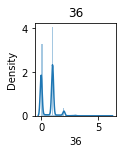

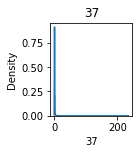

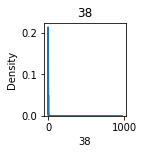

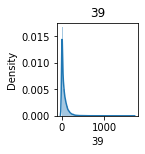

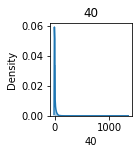

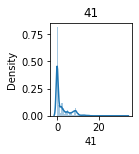

In [39]:
x_df = pd.DataFrame(x_train_over)
for i in range(1,43):
  plt.figure(figsize=(12,12))
  plt.subplot(6,7,i)
  plt.title(str(i-1))
  sns.distplot(x_df[i-1])

In [40]:
log_x_train_over = np.log1p(x_train_over)
log_x_train_over

array([[0.        , 0.        , 2.19722458, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 4.73619845, 4.04305127,
        0.69314718],
       [0.        , 0.        , 1.09861229, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.15859618, 1.95431471,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [41]:
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
accuracies   = []

threshold = 0.5
# 모델 설정
def make_classifier(iterations=2000):
    clf = CatBoostClassifier(learning_rate=0.03,
                               iterations=iterations,
                               od_type="Iter",
                               early_stopping_rounds=200,
                               random_seed=42,
                              )
        
    return clf

#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(x_train_over):

    # split train, validation set
    X = log_x_train_over[train_idx]
    y = y_train_over[train_idx]
    valid_x = log_x_train_over[val_idx]
    valid_y = y_train_over[val_idx]

    #run traning
    clf = make_classifier()
    clf.fit(X, y, eval_set=(valid_x, valid_y), verbose=500)
    
    # cal valid prediction
    valid_prob = clf.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)
    accuracy  = accuracy_score(valid_y,valid_pred)

    # append scores
    models.append(clf)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)

    print('==========================================================')

0:	learn: 0.6792744	test: 0.6792076	best: 0.6792076 (0)	total: 19ms	remaining: 38s
500:	learn: 0.3456178	test: 0.3753853	best: 0.3753345 (498)	total: 8.42s	remaining: 25.2s
1000:	learn: 0.2980841	test: 0.3666496	best: 0.3666496 (1000)	total: 16.6s	remaining: 16.6s
1500:	learn: 0.2626711	test: 0.3653663	best: 0.3645886 (1348)	total: 25s	remaining: 8.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.364588601
bestIteration = 1348

Shrink model to first 1349 iterations.
0:	learn: 0.6789100	test: 0.6789103	best: 0.6789103 (0)	total: 18.1ms	remaining: 36.2s
500:	learn: 0.3483407	test: 0.3680420	best: 0.3680385 (499)	total: 8.37s	remaining: 25s
1000:	learn: 0.3020248	test: 0.3590595	best: 0.3590345 (999)	total: 16.8s	remaining: 16.7s
1500:	learn: 0.2660433	test: 0.3543721	best: 0.3543340 (1496)	total: 25.1s	remaining: 8.35s
1999:	learn: 0.2386151	test: 0.3533105	best: 0.3533105 (1999)	total: 33.4s	remaining: 0us

bestTest = 0.3533104677
bestIteration = 1999

0:	learn: 0

In [42]:
print(np.mean(auc_scores))
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(accuracies))

0.8350882193178405
0.9640365002683843
0.6552353155782561
0.8282


In [20]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [21]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [00:39<00:00, 420213.05it/s]

(14999, 42)


In [43]:
log_test_x = np.log1p(test_x)

In [44]:
pred_y_list = []
for model in models:
    pred_y = model.predict(log_test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [45]:
pred = np.where(pred_ensemble>0.5,1,0)
pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [46]:
sample_submission['problem'] = pred
sample_submission

,user_id,problem
0,30000,1
1,30001,0
2,30002,0
3,30003,1
4,30004,1
...,...,...
14994,44994,0
14995,44995,0
14996,44996,1
14997,44997,1


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/데이콘/submission/lgb_smote_submission_threshold0.5.csv')